# Further Research

Our previous points for further improving were:

1. Adding useful features to the data.
2. Experimenting with the classifers:    
    a. Using one user's classifier to predict another user's scores.    
    b. Try a different ML model.
3. Try aggregating entire dataset for learning and then predicting.
4. Better and faster interface for extracting the data once, and dynamicly choosing users to predict upon.

#### Imports

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score as acs
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Extracting dataset

In [2]:
from ReviewsData import *

In [3]:
N_USERS = 20
review_data = ReviewData(FILE_PATH, max_users=N_USERS)

2020-09-17 07:30:25,887 - DEBUG - Starting population of 20 users's reviews from 7911684 reviews in file.
2020-09-17 07:39:37,671 - DEBUG - Populated data structure successfully.


In [4]:
users = review_data.get_users_list()
print(users)

['A141HP4LYPWMSR', 'A328S9RN3U5M68', 'A1I7QGUDP043DG', 'A1M5405JH9THP9', 'ATXL536YX71TR', 'A3QYDL5CDNYN66', 'AQJVNDW6YZFQS', 'AD4CDZK7D31XP', 'A3Q4S5DFVPB70D', 'A2P7UB02HAVEPB', 'A2TX99AZKDK0V7', 'AFC8IKR407HSK', 'A1FRPGQYQTAOR1', 'A1RSDE90N6RSZF', 'A1OUBOGB5970AO', 'A3NPHQVIY59Y0Y', 'AFKMBAY28XO8A', 'A66KMXH9V7OGU', 'AFJ27ZV9183B8', 'AXMKAXC0TR9AW']


## Text cleaning tools

Removing punctuation & stopwords, tokenizing, and stemming.

In [5]:
import string
import re
import nltk

stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

In [6]:
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

## 1. Learning from certain user's data - with more features

This time we use more features: the 'time' feature and the 'summary' feature.

In [7]:
user = users[0]
user_reviews = review_data.get_user_reviews(user)
data = pd.DataFrame.from_records(user_reviews)
data = data.drop(columns=['productId', 'userId', 'profileName', 'helpfulness'])
data

2020-09-17 07:39:38,550 - DEBUG - Starting search for user reviews.
2020-09-17 07:39:38,554 - DEBUG - Returning user A141HP4LYPWMSR's  3649 reviews.


,score,time,summary,text
0,3.0,1182729600,"""There Is So Much Darkness Now ~ Come For The ...","Synopsis: On the daily trek from Juarez, Mexic..."
1,4.0,1161820800,We Are All Either Kings Or Pawns In The Game O...,The '02 release of `The Count of Monte Cristo'...
2,5.0,1170201600,"""Does Anyone Really Know?"" ~ Shamanic Excess A...",'The Doors' were one of the greatest rock and ...
3,5.0,1211414400,"""Bob's Your Uncle""",Released in `64 `Mary Poppins' is without ques...
4,3.0,1146787200,"Attack of the Giant Playmate, I Mean Leeches",11 out of 12 reviewers (now 12 with mine) are ...
...,...,...,...,...
3644,5.0,1304553600,"""In The Eyes Of God, We Are All Equal"" ~ Waiti...",`Earth' is the second film in Deepa Mehta's ci...
3645,5.0,1126483200,"""COME INTO ME!"" ~ Perceiving The Metaphysica...",What is it about this 1973 film dealing with t...
3646,5.0,1128816000,"""The Story Maybe Apocraphal, But I Believe It""","Carl Kolchak, the Night Stalker! Truly one of ..."
3647,3.0,1194912000,"""We Are One Smart Kid""",Disney's 'Meet the Robinson' is a fast paced a...


#### Split train/test

In [8]:
X = data[['time', 'summary', 'text']]
Y = data['score']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#### Vectorize text - using TF-IDF

In [9]:
def vectorize_text_tdif(data, train, test):
    vectorizer = TfidfVectorizer(analyzer=clean_text)
    vect_fit = vectorizer.fit(data)
    transformed_train = vect_fit.transform(train)
    transformed_test = vect_fit.transform(test)
    return transformed_train, transformed_test

def vectorize_text_BoW(data, train, test):
    vectorizer = CountVectorizer(analyzer=clean_text)
    vect_fit = vectorizer.fit(data)
    transformed_train = vect_fit.transform(train)
    transformed_test = vect_fit.transform(test)
    return transformed_train, transformed_test

In [10]:
X_train_text_vect, X_test_text_vect = vectorize_text_tdif(data['text'], X_train['text'], X_test['text'])
X_train_summary_vect, X_test_summary_vect = vectorize_text_tdif(data['summary'], X_train['summary'], X_test['summary'])

In [11]:
X_train_vect = pd.concat([X_train[['time']].reset_index(drop=True), 
           pd.DataFrame(X_train_summary_vect.toarray()), pd.DataFrame(X_train_text_vect.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['time']].reset_index(drop=True), 
           pd.DataFrame(X_test_summary_vect.toarray()), pd.DataFrame(X_test_text_vect.toarray())], axis=1)

X_train_vect.head()

,time,0,1,2,3,4,5,6,7,8,...,12389,12390,12391,12392,12393,12394,12395,12396,12397,12398
0,1212278400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1135468800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1279929600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1124928000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1295481600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Classifying

In [12]:
logging.basicConfig(level=logging.CRITICAL)

We will use Random Forests.

In [13]:
def get_rf_model(X_train_vect, y_train):
    rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)
    rf_model = rf.fit(X_train_vect, y_train)
    return rf_model

def test_rf_model(rf_model, X_test_vect, y_test):
    logging.basicConfig(level=logging.CRITICAL)
    y_pred = rf_model.predict(X_test_vect)

    precision, recall, fscore, train_support = score(y_test, y_pred, labels=[1.0, 2.0, 3.0, 4.0, 5.0], average=None)
    print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}'.format(
        precision, recall, fscore, acs(y_test,y_pred)))

    # Making the Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    class_label = [1.0, 2.0, 3.0, 4.0, 5.0]
    df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### Testing the results

In [14]:
rf_model = get_rf_model(X_train_vect, y_train)

C:\Users\dantc\anaconda3\envs\snap_env\lib\site-packages\numpy\lib\arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


Precision: [1.         1.         1.         0.97468354 0.94871795] / Recall: [1.         0.96       0.95512821 0.9625     0.9833887 ] / F1-Score: [1.         0.97959184 0.97704918 0.96855346 0.96574225] / Accuracy: 0.9698630136986301


2020-09-17 07:40:33,371 - DEBUG - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000196E45A2240>
2020-09-17 07:40:33,371 - DEBUG - Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000196E45A2240> on colorbar
2020-09-17 07:40:33,371 - DEBUG - Setting pcolormesh
2020-09-17 07:40:34,051 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2020-09-17 07:40:34,051 - DEBUG - findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
2020-09-17 07:40:34,051 - DEBUG - findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.335
2020-09-17 07:40:34,059 - DEBUG - findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335
2020-09-17 07:40:34,059 - DEBUG - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
2020-09-17 07:40:

2020-09-17 07:40:34,183 - DEBUG - findfont: score(<Font 'Tempus Sans ITC' (TEMPSITC.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:34,183 - DEBUG - findfont: score(<Font 'Modern No. 20' (MOD20.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:34,183 - DEBUG - findfont: score(<Font 'Arial' (ARIALN.TTF) normal normal 400 condensed>) = 6.613636363636363
2020-09-17 07:40:34,183 - DEBUG - findfont: score(<Font 'Comic Sans MS' (comicbd.ttf) normal normal 700 normal>) = 10.335
2020-09-17 07:40:34,183 - DEBUG - findfont: score(<Font 'Edwardian Script ITC' (ITCEDSCR.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:34,183 - DEBUG - findfont: score(<Font 'Arial' (ARIALNI.TTF) italic normal 400 condensed>) = 7.613636363636363
2020-09-17 07:40:34,191 - DEBUG - findfont: score(<Font 'Aharoni' (ahronbd.ttf) normal normal 700 normal>) = 10.335
2020-09-17 07:40:34,191 - DEBUG - findfont: score(<Font 'Javanese Text' (javatext.ttf) normal normal 400 normal>) = 10.05
2020-09-17 07

2020-09-17 07:40:34,319 - DEBUG - findfont: score(<Font 'Eras Light ITC' (ERASLGHT.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:34,327 - DEBUG - findfont: score(<Font 'Bell MT' (BELLI.TTF) italic normal 400 normal>) = 11.05
2020-09-17 07:40:34,335 - DEBUG - findfont: score(<Font 'Franklin Gothic Book' (FRABKIT.TTF) italic normal 400 normal>) = 11.05
2020-09-17 07:40:34,335 - DEBUG - findfont: score(<Font 'Times New Roman' (timesbd.ttf) normal normal 700 normal>) = 10.335
2020-09-17 07:40:34,335 - DEBUG - findfont: score(<Font 'Magneto' (MAGNETOB.TTF) normal normal 700 normal>) = 10.335
2020-09-17 07:40:34,335 - DEBUG - findfont: score(<Font 'Segoe UI' (seguisli.ttf) italic normal 350 normal>) = 11.0975
2020-09-17 07:40:34,335 - DEBUG - findfont: score(<Font 'Gisha' (gishabd.ttf) normal normal 700 normal>) = 10.335
2020-09-17 07:40:34,343 - DEBUG - findfont: score(<Font 'Webdings' (webdings.ttf) normal normal 400 normal>) = 10.05
2020-09-17 07:40:34,343 - DEBUG - findfont: s

2020-09-17 07:40:34,610 - DEBUG - findfont: score(<Font 'Arial' (arialbd.ttf) normal normal 700 normal>) = 6.698636363636363
2020-09-17 07:40:34,610 - DEBUG - findfont: score(<Font 'Britannic Bold' (BRITANIC.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:34,618 - DEBUG - findfont: score(<Font 'Century Gothic' (GOTHICB.TTF) normal normal 700 normal>) = 10.335
2020-09-17 07:40:34,618 - DEBUG - findfont: score(<Font 'Verdana' (verdanai.ttf) italic normal 400 normal>) = 4.6863636363636365
2020-09-17 07:40:34,618 - DEBUG - findfont: score(<Font 'Felix Titling' (FELIXTI.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:34,618 - DEBUG - findfont: score(<Font 'Franklin Gothic Medium Cond' (FRAMDCN.TTF) normal normal 400 condensed>) = 10.25
2020-09-17 07:40:34,618 - DEBUG - findfont: score(<Font 'Eras Bold ITC' (ERASBD.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:34,626 - DEBUG - findfont: score(<Font 'Gisha' (gishabd.ttf) normal normal 700 normal>) = 10.335
2020-09

2020-09-17 07:40:34,764 - DEBUG - findfont: score(<Font 'Constantia' (constanz.ttf) italic normal 700 normal>) = 11.335
2020-09-17 07:40:34,764 - DEBUG - findfont: score(<Font 'Bradley Hand ITC' (BRADHITC.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:34,764 - DEBUG - findfont: score(<Font 'Candara' (Candarai.ttf) italic normal 400 normal>) = 11.05
2020-09-17 07:40:34,772 - DEBUG - findfont: score(<Font 'Levenim MT' (lvnm.ttf) normal normal 400 normal>) = 10.05
2020-09-17 07:40:34,772 - DEBUG - findfont: score(<Font 'Gill Sans MT' (GIL_____.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:34,772 - DEBUG - findfont: score(<Font 'Maiandra GD' (MAIAN.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:34,772 - DEBUG - findfont: score(<Font 'Sitka Small' (Sitka.ttc) normal normal 400 normal>) = 10.05
2020-09-17 07:40:34,772 - DEBUG - findfont: score(<Font 'Times New Roman' (timesi.ttf) italic normal 400 normal>) = 11.05
2020-09-17 07:40:34,780 - DEBUG - findfont: sco

2020-09-17 07:40:34,905 - DEBUG - findfont: score(<Font 'Calibri' (calibrii.ttf) italic normal 400 normal>) = 11.05
2020-09-17 07:40:34,905 - DEBUG - findfont: score(<Font 'Segoe UI' (seguibli.ttf) italic normal 900 normal>) = 11.525
2020-09-17 07:40:34,913 - DEBUG - findfont: score(<Font 'Tw Cen MT' (TCMI____.TTF) italic normal 400 normal>) = 11.05
2020-09-17 07:40:34,913 - DEBUG - findfont: score(<Font 'Narkisim' (nrkis.ttf) normal normal 400 normal>) = 10.05
2020-09-17 07:40:34,913 - DEBUG - findfont: score(<Font 'Bahnschrift' (bahnschrift.ttf) normal normal 400 normal>) = 10.05
2020-09-17 07:40:34,913 - DEBUG - findfont: score(<Font 'Bodoni MT' (BOD_CR.TTF) normal normal 400 condensed>) = 10.25
2020-09-17 07:40:34,913 - DEBUG - findfont: score(<Font 'Parchment' (PARCHM.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:34,921 - DEBUG - findfont: score(<Font 'Franklin Gothic Heavy' (FRAHVIT.TTF) italic normal 400 normal>) = 11.05
2020-09-17 07:40:34,921 - DEBUG - findfont: sco

2020-09-17 07:40:35,054 - DEBUG - findfont: score(<Font 'Forte' (FORTE.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:35,062 - DEBUG - findfont: score(<Font 'Calibri' (calibril.ttf) normal normal 300 normal>) = 10.145
2020-09-17 07:40:35,062 - DEBUG - findfont: score(<Font 'Arial' (arialbi.ttf) italic normal 700 normal>) = 7.698636363636363
2020-09-17 07:40:35,062 - DEBUG - findfont: score(<Font 'Cooper Black' (COOPBL.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:35,062 - DEBUG - findfont: score(<Font 'Miriam Fixed' (mriamc.ttf) normal normal 400 normal>) = 10.05
2020-09-17 07:40:35,070 - DEBUG - findfont: score(<Font 'Bookman Old Style' (BOOKOS.TTF) normal normal 300 normal>) = 10.145
2020-09-17 07:40:35,070 - DEBUG - findfont: score(<Font 'Lucida Bright' (LBRITEDI.TTF) italic normal 600 normal>) = 11.24
2020-09-17 07:40:35,070 - DEBUG - findfont: score(<Font 'Showcard Gothic' (SHOWG.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:35,078 - DEBUG - findfon

2020-09-17 07:40:35,214 - DEBUG - findfont: score(<Font 'Gill Sans Ultra Bold' (GILSANUB.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:35,214 - DEBUG - findfont: score(<Font 'Calisto MT' (CALIST.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:35,214 - DEBUG - findfont: score(<Font 'Berlin Sans FB' (BRLNSB.TTF) normal normal 700 normal>) = 10.335
2020-09-17 07:40:35,222 - DEBUG - findfont: score(<Font 'Impact' (impact.ttf) normal normal 400 normal>) = 10.05
2020-09-17 07:40:35,222 - DEBUG - findfont: score(<Font 'Lucida Fax' (LFAXDI.TTF) italic normal 600 normal>) = 11.24
2020-09-17 07:40:35,222 - DEBUG - findfont: score(<Font 'Gill Sans MT Condensed' (GILC____.TTF) normal normal 400 condensed>) = 10.25
2020-09-17 07:40:35,222 - DEBUG - findfont: score(<Font 'Eras Demi ITC' (ERASDEMI.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:35,230 - DEBUG - findfont: score(<Font 'Microsoft PhagsPa' (phagspab.ttf) normal normal 700 normal>) = 10.335
2020-09-17 07:40:35

2020-09-17 07:40:35,355 - DEBUG - findfont: score(<Font 'Felix Titling' (FELIXTI.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:35,355 - DEBUG - findfont: score(<Font 'Rockwell' (ROCKI.TTF) italic normal 400 normal>) = 11.05
2020-09-17 07:40:35,355 - DEBUG - findfont: score(<Font 'Century Schoolbook' (SCHLBKB.TTF) normal normal 700 normal>) = 10.335
2020-09-17 07:40:35,363 - DEBUG - findfont: score(<Font 'HoloLens MDL2 Assets' (holomdl2.ttf) normal normal 400 normal>) = 10.05
2020-09-17 07:40:35,363 - DEBUG - findfont: score(<Font 'Calisto MT' (CALIST.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:35,363 - DEBUG - findfont: score(<Font 'Georgia' (georgia.ttf) normal normal 400 normal>) = 10.05
2020-09-17 07:40:35,371 - DEBUG - findfont: score(<Font 'OCR A Extended' (OCRAEXT.TTF) normal normal 400 expanded>) = 10.25
2020-09-17 07:40:35,371 - DEBUG - findfont: score(<Font 'Rage Italic' (RAGE.TTF) italic normal 400 normal>) = 11.05
2020-09-17 07:40:35,371 - DEBUG - fin

2020-09-17 07:40:35,507 - DEBUG - findfont: score(<Font 'Comic Sans MS' (comic.ttf) normal normal 400 normal>) = 10.05
2020-09-17 07:40:35,511 - DEBUG - findfont: score(<Font 'Trebuchet MS' (trebucbi.ttf) italic normal 700 normal>) = 11.335
2020-09-17 07:40:35,515 - DEBUG - findfont: score(<Font 'French Script MT' (FRSCRIPT.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:35,519 - DEBUG - findfont: score(<Font 'Tw Cen MT Condensed' (TCCM____.TTF) normal normal 400 condensed>) = 10.25
2020-09-17 07:40:35,519 - DEBUG - findfont: score(<Font 'Candara' (Candaral.ttf) normal normal 400 normal>) = 10.05
2020-09-17 07:40:35,523 - DEBUG - findfont: score(<Font 'Lucida Sans' (LSANSD.TTF) normal normal 600 normal>) = 10.24
2020-09-17 07:40:35,527 - DEBUG - findfont: score(<Font 'Jokerman' (JOKERMAN.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:35,527 - DEBUG - findfont: score(<Font 'Bookman Old Style' (BOOKOSBI.TTF) italic normal 600 normal>) = 11.24
2020-09-17 07:40:35,527 - 

2020-09-17 07:40:35,794 - DEBUG - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
2020-09-17 07:40:35,794 - DEBUG - findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
2020-09-17 07:40:35,802 - DEBUG - findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
2020-09-17 07:40:35,802 - DEBUG - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
2020-09-17 07:40:35,802 - DEBUG - findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal 400 normal>) = 10.05
2020-09-17 07:40:35,802 - DEBUG - findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal 400 normal>) = 10.05
2020-09-17 07:40:35,802 - DEBUG - findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
2020-09-17 07:40:35,810 - DEBUG - findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 40

2020-09-17 07:40:35,936 - DEBUG - findfont: score(<Font 'Garamond' (GARAIT.TTF) italic normal 400 normal>) = 11.05
2020-09-17 07:40:35,936 - DEBUG - findfont: score(<Font 'Franklin Gothic Heavy' (FRAHV.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:35,936 - DEBUG - findfont: score(<Font 'Blackadder ITC' (ITCBLKAD.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:35,944 - DEBUG - findfont: score(<Font 'Symbol' (symbol.ttf) normal normal 400 normal>) = 10.05
2020-09-17 07:40:35,944 - DEBUG - findfont: score(<Font 'Bell MT' (BELLB.TTF) normal normal 700 normal>) = 10.335
2020-09-17 07:40:35,944 - DEBUG - findfont: score(<Font 'Elephant' (ELEPHNTI.TTF) italic normal 400 normal>) = 11.05
2020-09-17 07:40:35,944 - DEBUG - findfont: score(<Font 'Harlow Solid Italic' (HARLOWSI.TTF) italic normal 400 normal>) = 11.05
2020-09-17 07:40:35,944 - DEBUG - findfont: score(<Font 'Bodoni MT' (BOD_CR.TTF) normal normal 400 condensed>) = 10.25
2020-09-17 07:40:35,944 - DEBUG - findfont: 

2020-09-17 07:40:36,072 - DEBUG - findfont: score(<Font 'Harrington' (HARNGTON.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:36,072 - DEBUG - findfont: score(<Font 'Brush Script MT' (BRUSHSCI.TTF) italic normal 400 normal>) = 11.05
2020-09-17 07:40:36,080 - DEBUG - findfont: score(<Font 'Trebuchet MS' (trebucbi.ttf) italic normal 700 normal>) = 11.335
2020-09-17 07:40:36,080 - DEBUG - findfont: score(<Font 'Microsoft Tai Le' (taileb.ttf) normal normal 700 normal>) = 10.335
2020-09-17 07:40:36,080 - DEBUG - findfont: score(<Font 'Gill Sans MT Condensed' (GILC____.TTF) normal normal 400 condensed>) = 10.25
2020-09-17 07:40:36,080 - DEBUG - findfont: score(<Font 'Mongolian Baiti' (monbaiti.ttf) normal normal 400 normal>) = 10.05
2020-09-17 07:40:36,088 - DEBUG - findfont: score(<Font 'Yu Gothic' (YuGothR.ttc) normal normal 400 normal>) = 10.05
2020-09-17 07:40:36,088 - DEBUG - findfont: score(<Font 'Trebuchet MS' (trebucit.ttf) italic normal 400 normal>) = 11.05
2020-09-17 07:4

2020-09-17 07:40:36,206 - DEBUG - findfont: score(<Font 'Script MT Bold' (SCRIPTBL.TTF) normal normal 700 normal>) = 10.335
2020-09-17 07:40:36,206 - DEBUG - findfont: score(<Font 'David' (david.ttf) normal normal 400 normal>) = 10.05
2020-09-17 07:40:36,214 - DEBUG - findfont: score(<Font 'Harrington' (HARNGTON.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:36,214 - DEBUG - findfont: score(<Font 'Matura MT Script Capitals' (MATURASC.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:36,214 - DEBUG - findfont: score(<Font 'Gill Sans MT' (GILI____.TTF) italic normal 400 normal>) = 11.05
2020-09-17 07:40:36,214 - DEBUG - findfont: score(<Font 'Perpetua Titling MT' (PERTIBD.TTF) normal normal 700 normal>) = 10.335
2020-09-17 07:40:36,214 - DEBUG - findfont: score(<Font 'Curlz MT' (CURLZ___.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:36,214 - DEBUG - findfont: score(<Font 'Times New Roman' (timesbi.ttf) italic normal 700 normal>) = 11.335
2020-09-17 07:40:36,22

2020-09-17 07:40:36,340 - DEBUG - findfont: score(<Font 'Franklin Gothic Book' (FRABK.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:36,340 - DEBUG - findfont: score(<Font 'Kunstler Script' (KUNSTLER.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:36,348 - DEBUG - findfont: score(<Font 'Gigi' (GIGI.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:36,348 - DEBUG - findfont: score(<Font 'Marlett' (marlett.ttf) normal normal 500 normal>) = 10.145
2020-09-17 07:40:36,348 - DEBUG - findfont: score(<Font 'Yu Gothic' (YuGothB.ttc) normal normal 700 normal>) = 10.335
2020-09-17 07:40:36,348 - DEBUG - findfont: score(<Font 'Bodoni MT' (BOD_PSTC.TTF) normal normal 300 normal>) = 10.145
2020-09-17 07:40:36,348 - DEBUG - findfont: score(<Font 'Nirmala UI' (Nirmala.ttf) normal normal 400 normal>) = 10.05
2020-09-17 07:40:36,356 - DEBUG - findfont: score(<Font 'Blackadder ITC' (ITCBLKAD.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:36,356 - DEBUG - findfont: sco

2020-09-17 07:40:36,467 - DEBUG - findfont: score(<Font 'Bodoni MT' (BOD_BLAI.TTF) italic normal 900 normal>) = 11.525
2020-09-17 07:40:36,468 - DEBUG - findfont: score(<Font 'Verdana' (verdana.ttf) normal normal 400 normal>) = 3.6863636363636365
2020-09-17 07:40:36,474 - DEBUG - findfont: score(<Font 'Gill Sans MT' (GILB____.TTF) normal normal 700 normal>) = 10.335
2020-09-17 07:40:36,478 - DEBUG - findfont: score(<Font 'Arial' (ARIALNB.TTF) normal normal 700 condensed>) = 6.8986363636363635
2020-09-17 07:40:36,479 - DEBUG - findfont: score(<Font 'Baskerville Old Face' (BASKVILL.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:36,482 - DEBUG - findfont: score(<Font 'Candara' (Candarab.ttf) normal normal 700 normal>) = 10.335
2020-09-17 07:40:36,484 - DEBUG - findfont: score(<Font 'Bauhaus 93' (BAUHS93.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:36,485 - DEBUG - findfont: score(<Font 'Gloucester MT Extra Condensed' (GLECB.TTF) normal normal 400 condensed>) = 10.25


2020-09-17 07:40:36,604 - DEBUG - findfont: score(<Font 'Segoe UI' (seguisbi.ttf) italic normal 600 normal>) = 11.24
2020-09-17 07:40:36,604 - DEBUG - findfont: score(<Font 'Niagara Engraved' (NIAGENG.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:36,604 - DEBUG - findfont: score(<Font 'Cambria' (cambriaz.ttf) italic normal 700 normal>) = 11.335
2020-09-17 07:40:36,604 - DEBUG - findfont: score(<Font 'Papyrus' (PAPYRUS.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:36,604 - DEBUG - findfont: score(<Font 'Lucida Sans' (LSANSI.TTF) italic normal 400 normal>) = 11.05
2020-09-17 07:40:36,612 - DEBUG - findfont: score(<Font 'Georgia' (georgiab.ttf) normal normal 700 normal>) = 10.335
2020-09-17 07:40:36,612 - DEBUG - findfont: score(<Font 'Palatino Linotype' (palabi.ttf) italic normal 700 normal>) = 11.335
2020-09-17 07:40:36,612 - DEBUG - findfont: score(<Font 'Lucida Sans' (LSANS.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:36,612 - DEBUG - findfont: score(

2020-09-17 07:40:36,748 - DEBUG - findfont: score(<Font 'Californian FB' (CALIFR.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:36,748 - DEBUG - findfont: score(<Font 'Book Antiqua' (ANTQUAB.TTF) normal normal 700 normal>) = 10.335
2020-09-17 07:40:36,756 - DEBUG - findfont: score(<Font 'Consolas' (consola.ttf) normal normal 400 normal>) = 10.05
2020-09-17 07:40:36,756 - DEBUG - findfont: score(<Font 'Sitka Small' (SitkaB.ttc) normal normal 700 normal>) = 10.335
2020-09-17 07:40:36,756 - DEBUG - findfont: score(<Font 'Agency FB' (AGENCYR.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:36,756 - DEBUG - findfont: score(<Font 'Segoe UI' (segoeuii.ttf) italic normal 400 normal>) = 11.05
2020-09-17 07:40:36,764 - DEBUG - findfont: score(<Font 'Nirmala UI' (Nirmala.ttf) normal normal 400 normal>) = 10.05
2020-09-17 07:40:36,764 - DEBUG - findfont: score(<Font 'Lucida Bright' (LBRITE.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:36,764 - DEBUG - findfont: score(<

2020-09-17 07:40:36,884 - DEBUG - findfont: score(<Font 'Rockwell' (ROCKBI.TTF) italic normal 700 normal>) = 11.335
2020-09-17 07:40:36,884 - DEBUG - findfont: score(<Font 'Segoe Script' (segoesc.ttf) normal normal 400 normal>) = 10.05
2020-09-17 07:40:36,884 - DEBUG - findfont: score(<Font 'MS Outlook' (OUTLOOK.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:36,900 - DEBUG - findfont: score(<Font 'Agency FB' (AGENCYR.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:36,900 - DEBUG - findfont: score(<Font 'Chiller' (CHILLER.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:36,900 - DEBUG - findfont: score(<Font 'Tw Cen MT' (TCM_____.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:36,900 - DEBUG - findfont: score(<Font 'Corbel' (corbelz.ttf) italic normal 700 normal>) = 11.335
2020-09-17 07:40:36,908 - DEBUG - findfont: score(<Font 'Cambria' (cambria.ttc) normal normal 400 normal>) = 10.05
2020-09-17 07:40:36,908 - DEBUG - findfont: score(<Font 'Berlin Sa

2020-09-17 07:40:37,036 - DEBUG - findfont: score(<Font 'Wingdings 2' (WINGDNG2.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:37,036 - DEBUG - findfont: score(<Font 'SimSun-ExtB' (simsunb.ttf) normal normal 400 normal>) = 10.05
2020-09-17 07:40:37,044 - DEBUG - findfont: score(<Font 'Sitka Small' (Sitka.ttc) normal normal 400 normal>) = 10.05
2020-09-17 07:40:37,044 - DEBUG - findfont: score(<Font 'Stencil' (STENCIL.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:37,044 - DEBUG - findfont: score(<Font 'Candara' (Candarab.ttf) normal normal 700 normal>) = 10.335
2020-09-17 07:40:37,044 - DEBUG - findfont: score(<Font 'David' (david.ttf) normal normal 400 normal>) = 10.05
2020-09-17 07:40:37,044 - DEBUG - findfont: score(<Font 'Californian FB' (CALIFI.TTF) italic normal 400 normal>) = 11.05
2020-09-17 07:40:37,044 - DEBUG - findfont: score(<Font 'Cambria' (cambriab.ttf) normal normal 700 normal>) = 10.335
2020-09-17 07:40:37,052 - DEBUG - findfont: score(<Font 'Centau

2020-09-17 07:40:37,172 - DEBUG - findfont: score(<Font 'MT Extra' (MTEXTRA.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:37,180 - DEBUG - findfont: score(<Font 'Snap ITC' (SNAP____.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:37,180 - DEBUG - findfont: score(<Font 'Gisha' (gisha.ttf) normal normal 400 normal>) = 10.05
2020-09-17 07:40:37,180 - DEBUG - findfont: score(<Font 'Corbel' (corbelb.ttf) normal normal 700 normal>) = 10.335
2020-09-17 07:40:37,180 - DEBUG - findfont: score(<Font 'Nirmala UI' (NirmalaS.ttf) normal normal 350 normal>) = 10.0975
2020-09-17 07:40:37,180 - DEBUG - findfont: score(<Font 'Kristen ITC' (ITCKRIST.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:37,180 - DEBUG - findfont: score(<Font 'Lucida Fax' (LFAX.TTF) normal normal 400 normal>) = 10.05
2020-09-17 07:40:37,180 - DEBUG - findfont: score(<Font 'Arial' (ARIALNBI.TTF) italic normal 700 condensed>) = 7.8986363636363635
2020-09-17 07:40:37,188 - DEBUG - findfont: score(<Font

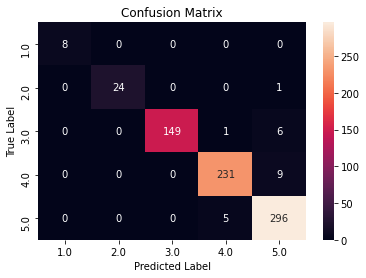

In [15]:
test_rf_model(rf_model, X_test_vect, y_test)

Seems like a good classifier.

## 2. Aggregating entire dataset for learning and then predicting.

In [16]:
allusers_reviews = review_data.get_all_reviews()

allusers_data = pd.DataFrame.from_records(allusers_reviews)
allusers_data = allusers_data.drop(columns=['profileName', 'helpfulness'])
allusers_data

2020-09-17 07:40:37,593 - DEBUG - Starting retrieval of all user reviews.
2020-09-17 07:40:37,603 - DEBUG - Done


,productId,userId,score,time,summary,text
0,B003AI2VGA,A141HP4LYPWMSR,3.0,1182729600,"""There Is So Much Darkness Now ~ Come For The ...","Synopsis: On the daily trek from Juarez, Mexic..."
1,B000063W1R,A141HP4LYPWMSR,4.0,1161820800,We Are All Either Kings Or Pawns In The Game O...,The '02 release of `The Count of Monte Cristo'...
2,6304286961,A141HP4LYPWMSR,5.0,1170201600,"""Does Anyone Really Know?"" ~ Shamanic Excess A...",'The Doors' were one of the greatest rock and ...
3,5556167281,A141HP4LYPWMSR,5.0,1211414400,"""Bob's Your Uncle""",Released in `64 `Mary Poppins' is without ques...
4,6303998690,A141HP4LYPWMSR,3.0,1146787200,"Attack of the Giant Playmate, I Mean Leeches",11 out of 12 reviewers (now 12 with mine) are ...
...,...,...,...,...,...,...
14924,B0007TFH70,AXMKAXC0TR9AW,5.0,1120176000,Contains All The Hit Songs And Interviews,I am very pleased with this DVD. It includes ...
14925,B0008FXSQU,AXMKAXC0TR9AW,4.0,1131148800,An Enjoyable half hour,As others have listed there are seven (7) Herm...
14926,6304749910,AXMKAXC0TR9AW,5.0,1011744000,A Video to Watch Numerous Times,Whether or not a video or movie deserves an &q...
14927,B00004CS3W,AXMKAXC0TR9AW,5.0,1010880000,This Movie is Timeless,I remember seeing this movie in 1955 when I wa...


In [17]:
X_all = allusers_data[['productId', 'userId', 'time', 'summary', 'text']]
Y_all = allusers_data['score']

X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all, Y_all, test_size=0.2, random_state=42)

In [18]:
logging.debug('Starting vectorization.')

X_all_train_vect = dict()
X_all_test_vect = dict()

X_all_train_vect['text'], X_all_test_vect['text'] = vectorize_text_tdif(allusers_data['text'], X_all_train['text'], X_all_test['text'])
X_all_train_vect['summary'], X_all_test_vect['summary'] = vectorize_text_tdif(allusers_data['summary'], X_all_train['summary'], X_all_test['summary'])
X_all_train_vect['productId'], X_all_test_vect['productId'] = vectorize_text_BoW(allusers_data['productId'], X_all_train['productId'], X_all_test['productId'])
X_all_train_vect['userId'], X_all_test_vect['userId'] = vectorize_text_BoW(allusers_data['userId'], X_all_train['userId'], X_all_test['userId'])

logging.debug('Done.')

2020-09-17 07:40:37,793 - DEBUG - Starting vectorization.
2020-09-17 07:44:33,743 - DEBUG - Done.


In [20]:
X_all_train_vect = pd.concat([X_all_train[['time']].reset_index(drop=True),
                              pd.DataFrame(X_all_train_vect['productId'].toarray()),
                              pd.DataFrame(X_all_train_vect['userId'].toarray()),
                              pd.DataFrame(X_all_train_vect['summary'].toarray()),
                              pd.DataFrame(X_all_train_vect['text'].toarray())], axis=1)
X_all_test_vect = pd.concat([X_all_test[['time']].reset_index(drop=True),
                              pd.DataFrame(X_all_test_vect['productId'].toarray()),
                              pd.DataFrame(X_all_test_vect['userId'].toarray()),
                              pd.DataFrame(X_all_test_vect['summary'].toarray()),
                              pd.DataFrame(X_all_test_vect['text'].toarray())], axis=1)

X_all_train_vect.head()

,time,0,1,2,3,4,5,6,7,8,...,43426,43427,43428,43429,43430,43431,43432,43433,43434,43435
0,951696000,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1099267200,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1189382400,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1304812800,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1149897600,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Now testing the orig model on this user's reviews
At the moment we can see that we have issues of memory allocation (due to my 8G RAM PC..). Putting a pin in this and researching other areas.

In [21]:
logging.debug('Fitting model.')
rf_model = get_rf_model(X_all_train_vect, y_all_train)
logging.debug('Done.')

2020-09-17 07:47:42,781 - DEBUG - Fitting model.


MemoryError: Unable to allocate 1.11 GiB for an array with shape (12419, 11943) and data type object